In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from collections import defaultdict
import os
from evaluate_flipflop import get_base_accuracy, get_digit_accuracy, get_relaxed_distance_accuracy, get_strict_distance_accuracy, get_per_dist_accuracy

In [54]:
def get_data(path):
    with open(path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

In [55]:
def get_of_length(length, path):
    data = get_data(path)

    flipflop_of_length = []
    for line in data:
        if len(line['flipflop']) == length:
            flipflop_of_length.append(line)

    return flipflop_of_length

In [56]:
# could have just taken lengths and positions from the file name but oh well
def count_custom_length(input_string):
    # Define keywords and their lengths
    keywords = ["write", "read", "ignore"]
    keyword_length = 1

    i = 0
    total_length = 0

    while i < len(input_string):
        # Check if the substring matches any of the keywords
        matched = False
        for keyword in keywords:
            if input_string[i:i+len(keyword)] == keyword:
                total_length += keyword_length
                i += len(keyword)
                matched = True
                break

        # If no keyword matches, check if it's a digit
        if not matched:
            if input_string[i].isdigit():
                total_length += 1
                i += 1
            else:
                raise ValidationError

    return total_length

In [57]:
def find_last_write_idx(input_string):
    pattern = r'(write|read|ignore)([01])'
    
    matches = re.findall(pattern, input_string)
    
    result = []
    for action, number in matches:
        result.append(action)
        result.append(number)

    for i in range(len(result)-1, -1, -1):
        if result[i] == "write":
            return i

In [58]:
def plot_model_accuracy(models, title, output_path):
    """
    Creates a grouped histogram plot of average base accuracy by flipflop length across models.

    Args:
        models (dict): Dictionary where keys are model names and values are lists of folder paths.
        output_path (str): Path to save the generated plot.

    Returns:
        None
    """
    # Aggregate results for all models
    results_by_model = {}
    for model_name, folders in models.items():
        all_samples = []
        for folder_path in folders:
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".jsonl"):
                    file_path = os.path.join(folder_path, file_name)
                    with open(file_path, 'r', encoding='utf-8') as file:
                        one_sample_data = [json.loads(line) for line in file]
                        all_samples.append(one_sample_data)

        # Aggregate accuracies by sparse length
        acc_by_length = defaultdict(list)
        for result in all_samples:
            acc = get_base_accuracy(result)
            if 'worded' in model_name:
                length = count_custom_length(result[0]['flipflop'])
            else:
                length = len(result[0]['flipflop'])
            acc_by_length[length].append(acc)

        # Calculate average accuracy for each sparse length
        average_acc_by_length = {length: sum(accs) / len(accs) for length, accs in acc_by_length.items()}
        results_by_model[model_name] = average_acc_by_length

    # Extract lengths in steps of 50 and prepare data for plotting
    all_lengths = sorted(set(k for model_results in results_by_model.values() for k in model_results.keys()))
    selected_lengths = [length for length in all_lengths if length % 50 == 0]

    # Prepare data for grouped histogram
    plot_data = {model: [results_by_model[model].get(length, 0) for length in selected_lengths] for model in models.keys()}

    # Plot grouped histogram
    x = np.arange(len(selected_lengths))  # the label locations
    width = 0.15  # the width of the bars

    fig, ax = plt.subplots(figsize=(26, 7))
    for i, (model, accuracies) in enumerate(plot_data.items()):
        ax.bar(x + i * width, accuracies, width, label=model)

    baseline = 0.5
    ax.axhline(y=baseline, color='red', linestyle='--', linewidth=1.5, label='50% Baseline')

    # Add labels, title, and legend
    ax.set_xlabel('Flipflop Length')
    ax.set_ylabel('Average Base Accuracy')
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(selected_lengths)
    ax.legend(fontsize=14)

    # Show grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


# SPARSE

# All models on subtasks (regular, worded, qa, qa-worded)

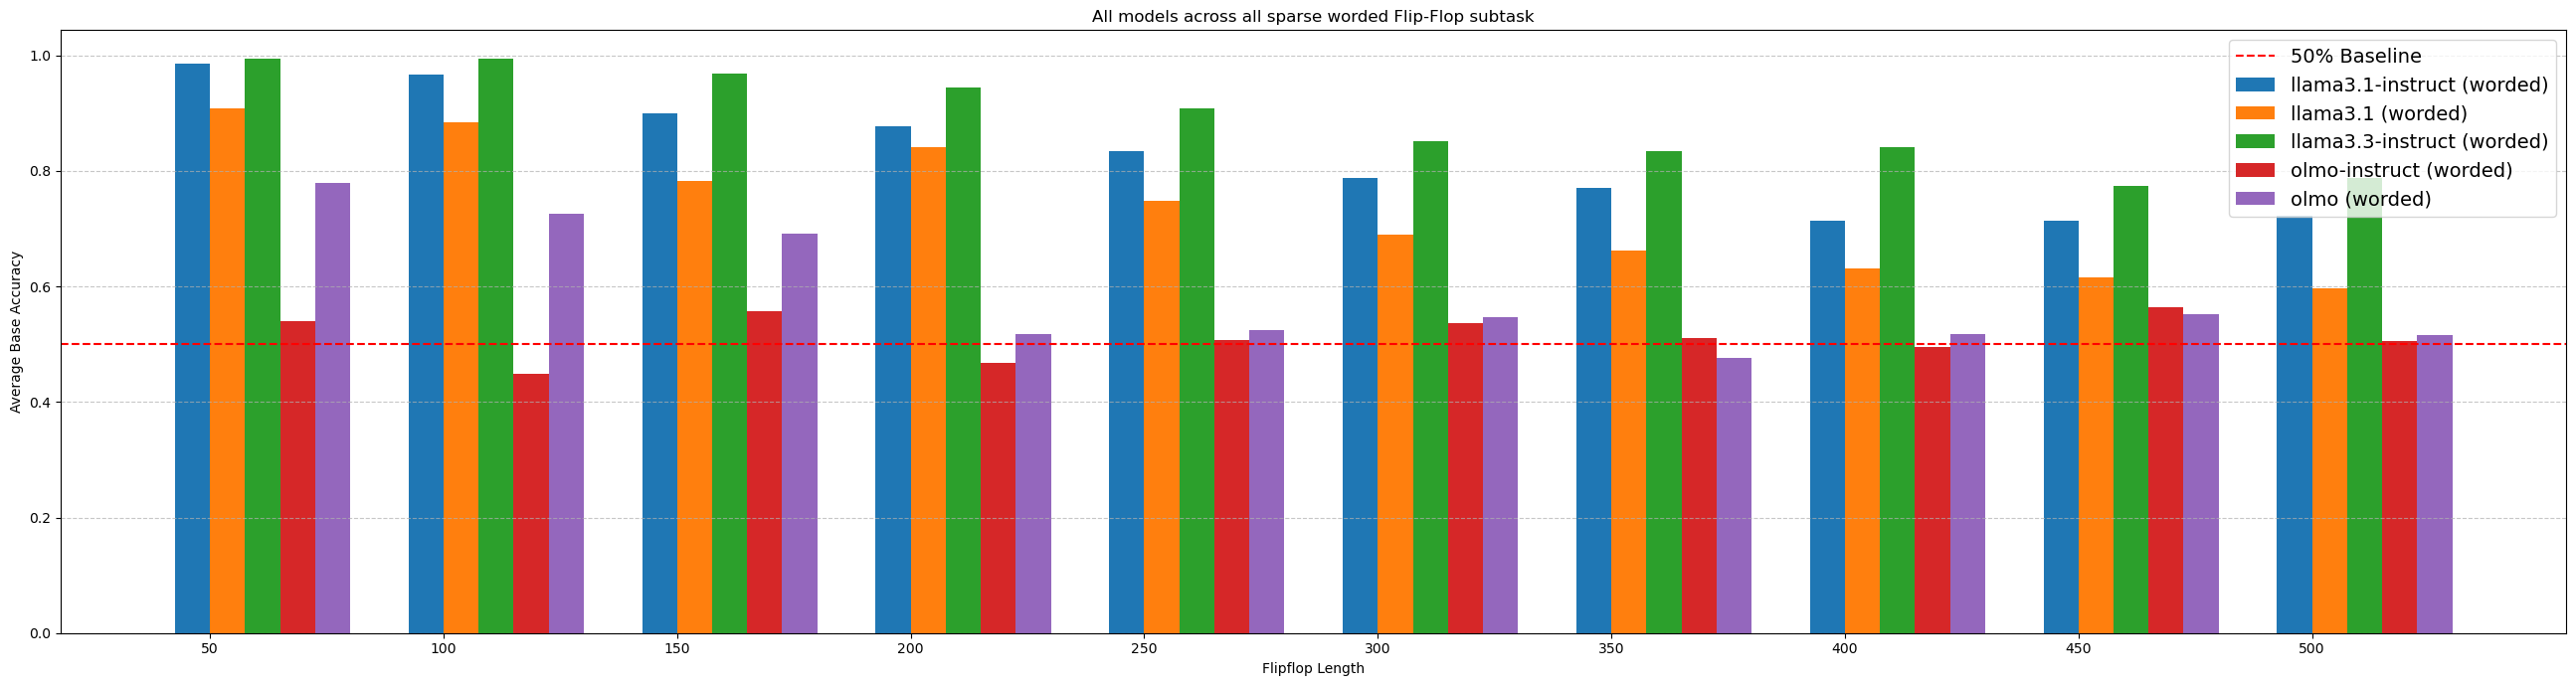

In [59]:
# SPARSE WORDED
models = {
    "llama3.1-instruct (worded)": ["llama3.1_70B-instruct/sparse-worded/s1", 
                          "llama3.1_70B-instruct/sparse-worded/s2", 
                          "llama3.1_70B-instruct/sparse-worded/s3", 
                          "llama3.1_70B-instruct/sparse-worded/s4", 
                          "llama3.1_70B-instruct/sparse-worded/s5"],
    "llama3.1 (worded)": ["llama3.1_70B/sparse-worded/s1", 
                 "llama3.1_70B/sparse-worded/s2", 
                 "llama3.1_70B/sparse-worded/s3", 
                 "llama3.1_70B/sparse-worded/s4", 
                 "llama3.1_70B/sparse-worded/s5"],
        "llama3.3-instruct (worded)": ["llama3.3_70B-instruct/sparse-worded/s1", 
                 "llama3.3_70B-instruct/sparse-worded/s2", 
                 "llama3.3_70B-instruct/sparse-worded/s3", 
                 "llama3.3_70B-instruct/sparse-worded/s4", 
                 "llama3.3_70B-instruct/sparse-worded/s5"],
    "olmo-instruct (worded)": ["OLMo_7B-instruct/sparse-worded/s1", 
                         "OLMo_7B-instruct/sparse-worded/s2",
                         "OLMo_7B-instruct/sparse-worded/s3",
                         "OLMo_7B-instruct/sparse-worded/s4",
                         "OLMo_7B-instruct/sparse-worded/s5"],
    "olmo (worded)": ["OLMo_7B/sparse-worded/s1", 
            "OLMo_7B/sparse-worded/s2",
            "OLMo_7B/sparse-worded/s3",
            "OLMo_7B/sparse-worded/s4",
            "OLMo_7B/sparse-worded/s5"],
}
title = "All models across all sparse worded Flip-Flop subtask"
output_path = 'graphs/models_across_sparse_worded_flipflop.png'

plot_model_accuracy(models, title, output_path)


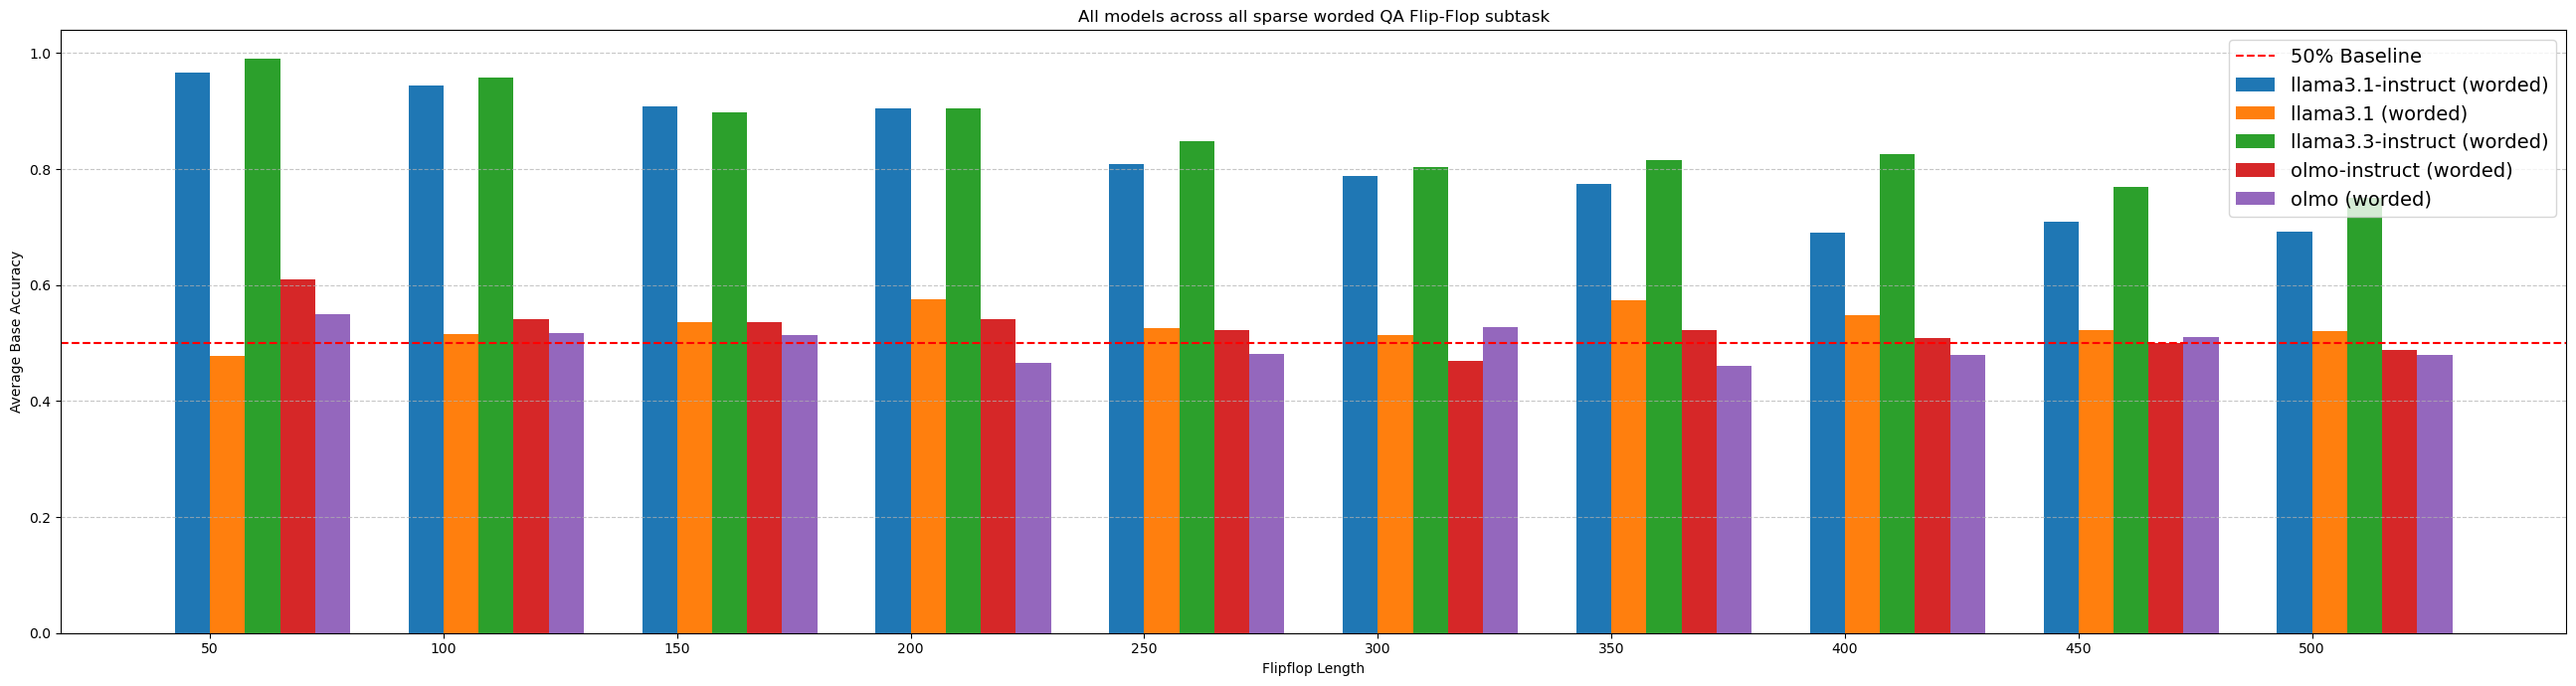

In [60]:
# SPARSE QA WORDED
models = {
    "llama3.1-instruct (worded)": ["llama3.1_70B-instruct/sparse-qa-worded/s1", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s2", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s3", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s4", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s5"],
    "llama3.1 (worded)": ["llama3.1_70B/sparse-qa-worded/s1", 
                 "llama3.1_70B/sparse-qa-worded/s2", 
                 "llama3.1_70B/sparse-qa-worded/s3", 
                 "llama3.1_70B/sparse-qa-worded/s4", 
                 "llama3.1_70B/sparse-qa-worded/s5"],
        "llama3.3-instruct (worded)": ["llama3.3_70B-instruct/sparse-qa-worded/s1", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s2", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s3", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s4", 
                 "llama3.3_70B-instruct/sparse-qa-worded/s5"],
    "olmo-instruct (worded)": ["OLMo_7B-instruct/sparse-qa-worded/s1", 
                         "OLMo_7B-instruct/sparse-qa-worded/s2",
                         "OLMo_7B-instruct/sparse-qa-worded/s3",
                         "OLMo_7B-instruct/sparse-qa-worded/s4",
                         "OLMo_7B-instruct/sparse-qa-worded/s5"],
    "olmo (worded)": ["OLMo_7B/sparse-qa-worded/s1", 
            "OLMo_7B/sparse-qa-worded/s2",
            "OLMo_7B/sparse-qa-worded/s3",
            "OLMo_7B/sparse-qa-worded/s4",
            "OLMo_7B/sparse-qa-worded/s5"],
}


title = "All models across all sparse worded QA Flip-Flop subtask"
output_path = 'graphs/models_across_sparse_worded_qa_flipflop.png'

plot_model_accuracy(models, title, output_path)

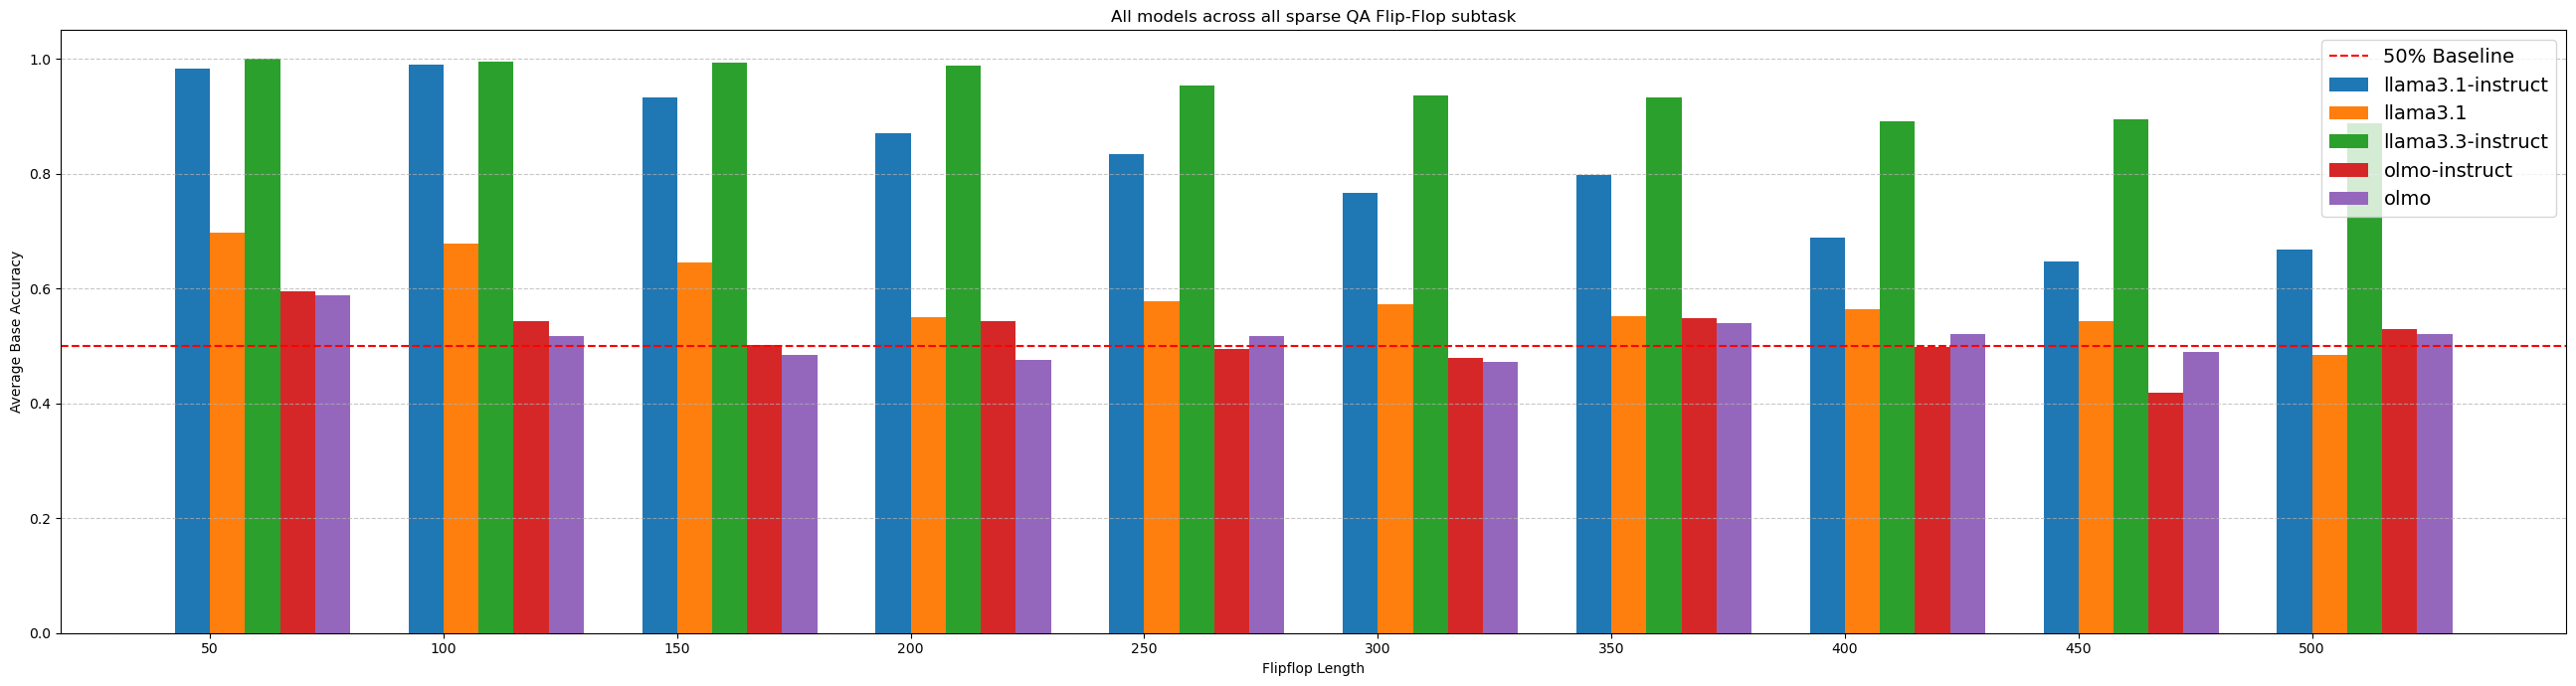

In [61]:
# SPARSE QA
models = {
    "llama3.1-instruct": ["llama3.1_70B-instruct/sparse-qa/s1", 
                          "llama3.1_70B-instruct/sparse-qa/s2", 
                          "llama3.1_70B-instruct/sparse-qa/s3", 
                          "llama3.1_70B-instruct/sparse-qa/s4", 
                          "llama3.1_70B-instruct/sparse-qa/s5"],
    "llama3.1": ["llama3.1_70B/sparse-qa/s1", 
                 "llama3.1_70B/sparse-qa/s2", 
                 "llama3.1_70B/sparse-qa/s3", 
                 "llama3.1_70B/sparse-qa/s4", 
                 "llama3.1_70B/sparse-qa/s5"],
        "llama3.3-instruct": ["llama3.3_70B-instruct/sparse-qa/s1", 
                 "llama3.3_70B-instruct/sparse-qa/s2", 
                 "llama3.3_70B-instruct/sparse-qa/s3", 
                 "llama3.3_70B-instruct/sparse-qa/s4", 
                 "llama3.3_70B-instruct/sparse-qa/s5"],
    "olmo-instruct": ["OLMo_7B-instruct/sparse-qa/s1", 
                         "OLMo_7B-instruct/sparse-qa/s2",
                         "OLMo_7B-instruct/sparse-qa/s3",
                         "OLMo_7B-instruct/sparse-qa/s4",
                         "OLMo_7B-instruct/sparse-qa/s5"],
    "olmo": ["OLMo_7B/sparse-qa/s1", 
            "OLMo_7B/sparse-qa/s2",
            "OLMo_7B/sparse-qa/s3",
            "OLMo_7B/sparse-qa/s4",
            "OLMo_7B/sparse-qa/s5"],
}
title = "All models across all sparse QA Flip-Flop subtask"
output_path = "graphs/models_across_sparse_qa_flipflop.png"
plot_model_accuracy(models, title, output_path)

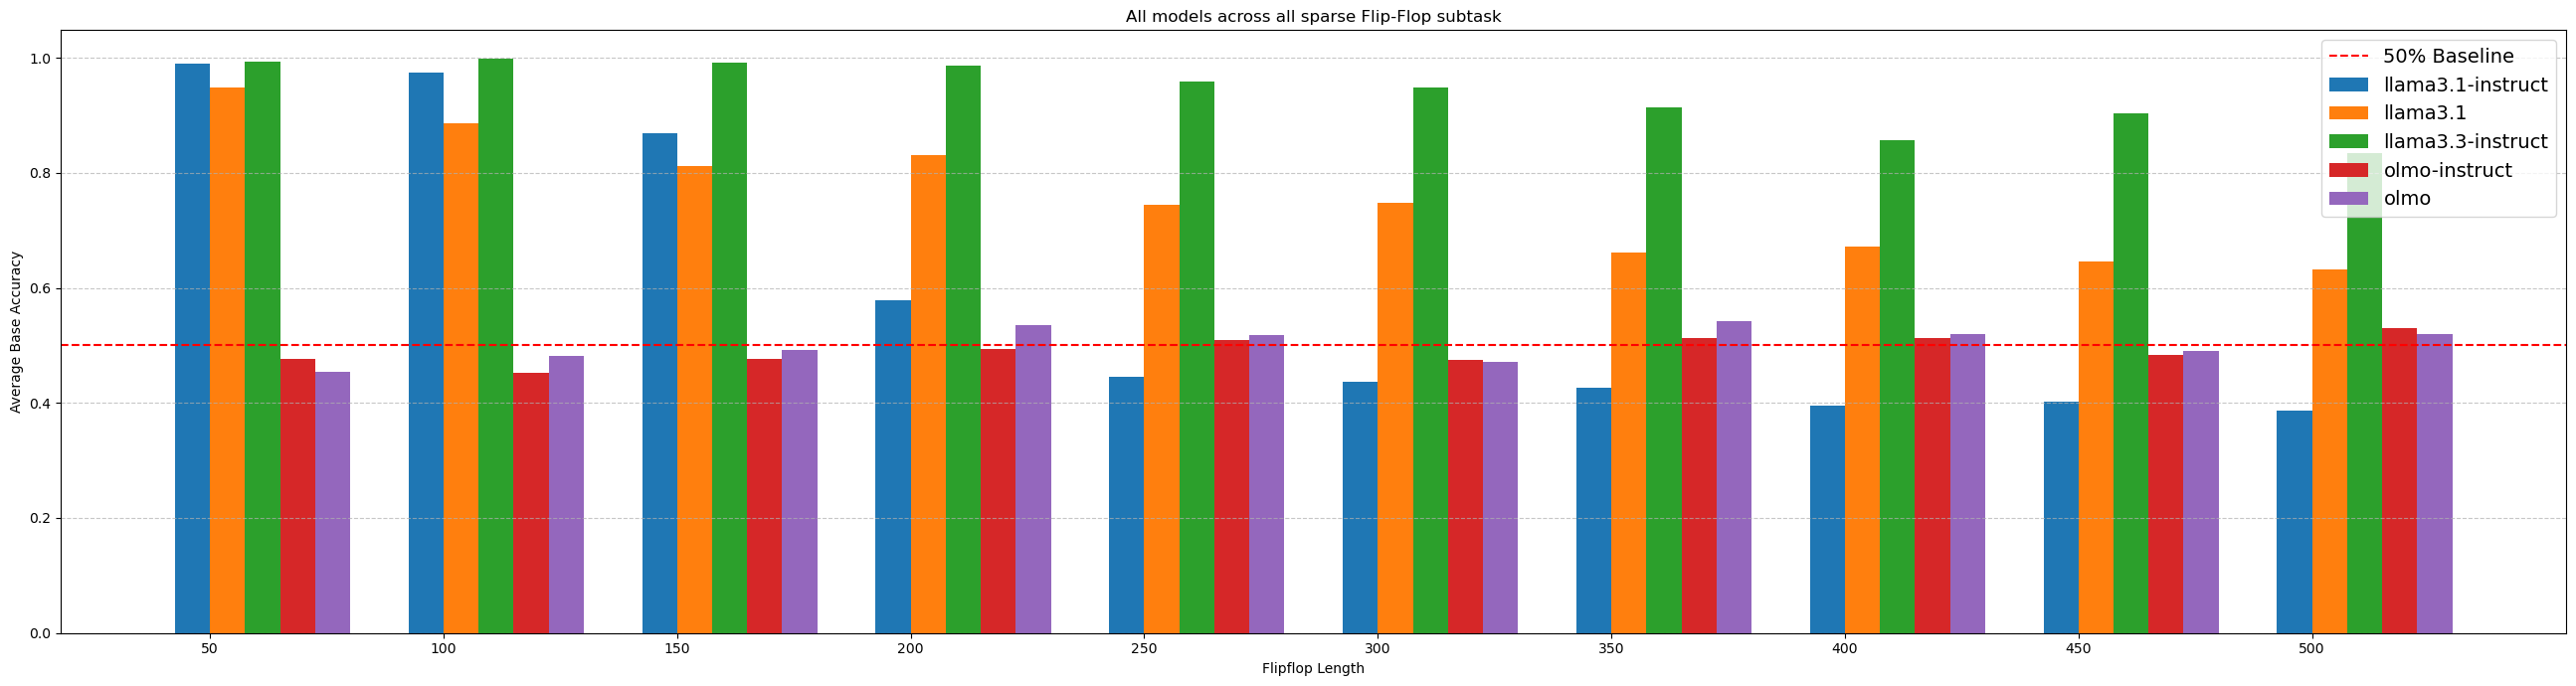

In [62]:
# SPARSE

models = {
    "llama3.1-instruct": ["llama3.1_70B-instruct/sparse/s1", 
                          "llama3.1_70B-instruct/sparse/s2", 
                          "llama3.1_70B-instruct/sparse/s3", 
                          "llama3.1_70B-instruct/sparse/s4", 
                          "llama3.1_70B-instruct/sparse/s5"],
    "llama3.1": ["llama3.1_70B/sparse/s1", 
                 "llama3.1_70B/sparse/s2", 
                 "llama3.1_70B/sparse/s3", 
                 "llama3.1_70B/sparse/s4", 
                 "llama3.1_70B/sparse/s5"],
        "llama3.3-instruct": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"],
    "olmo-instruct": ["OLMo_7B-instruct/sparse/s1", 
                         "OLMo_7B-instruct/sparse/s2",
                         "OLMo_7B-instruct/sparse/s3",
                         "OLMo_7B-instruct/sparse/s4",
                         "OLMo_7B-instruct/sparse/s5"],
    "olmo": ["OLMo_7B/sparse/s1", 
            "OLMo_7B/sparse/s2",
            "OLMo_7B/sparse/s3",
            "OLMo_7B/sparse/s4",
            "OLMo_7B/sparse/s5"],
}


title = "All models across all sparse Flip-Flop subtask"
output_path = "graphs/models_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# Llama 3.1 70B on all sparse subtasks

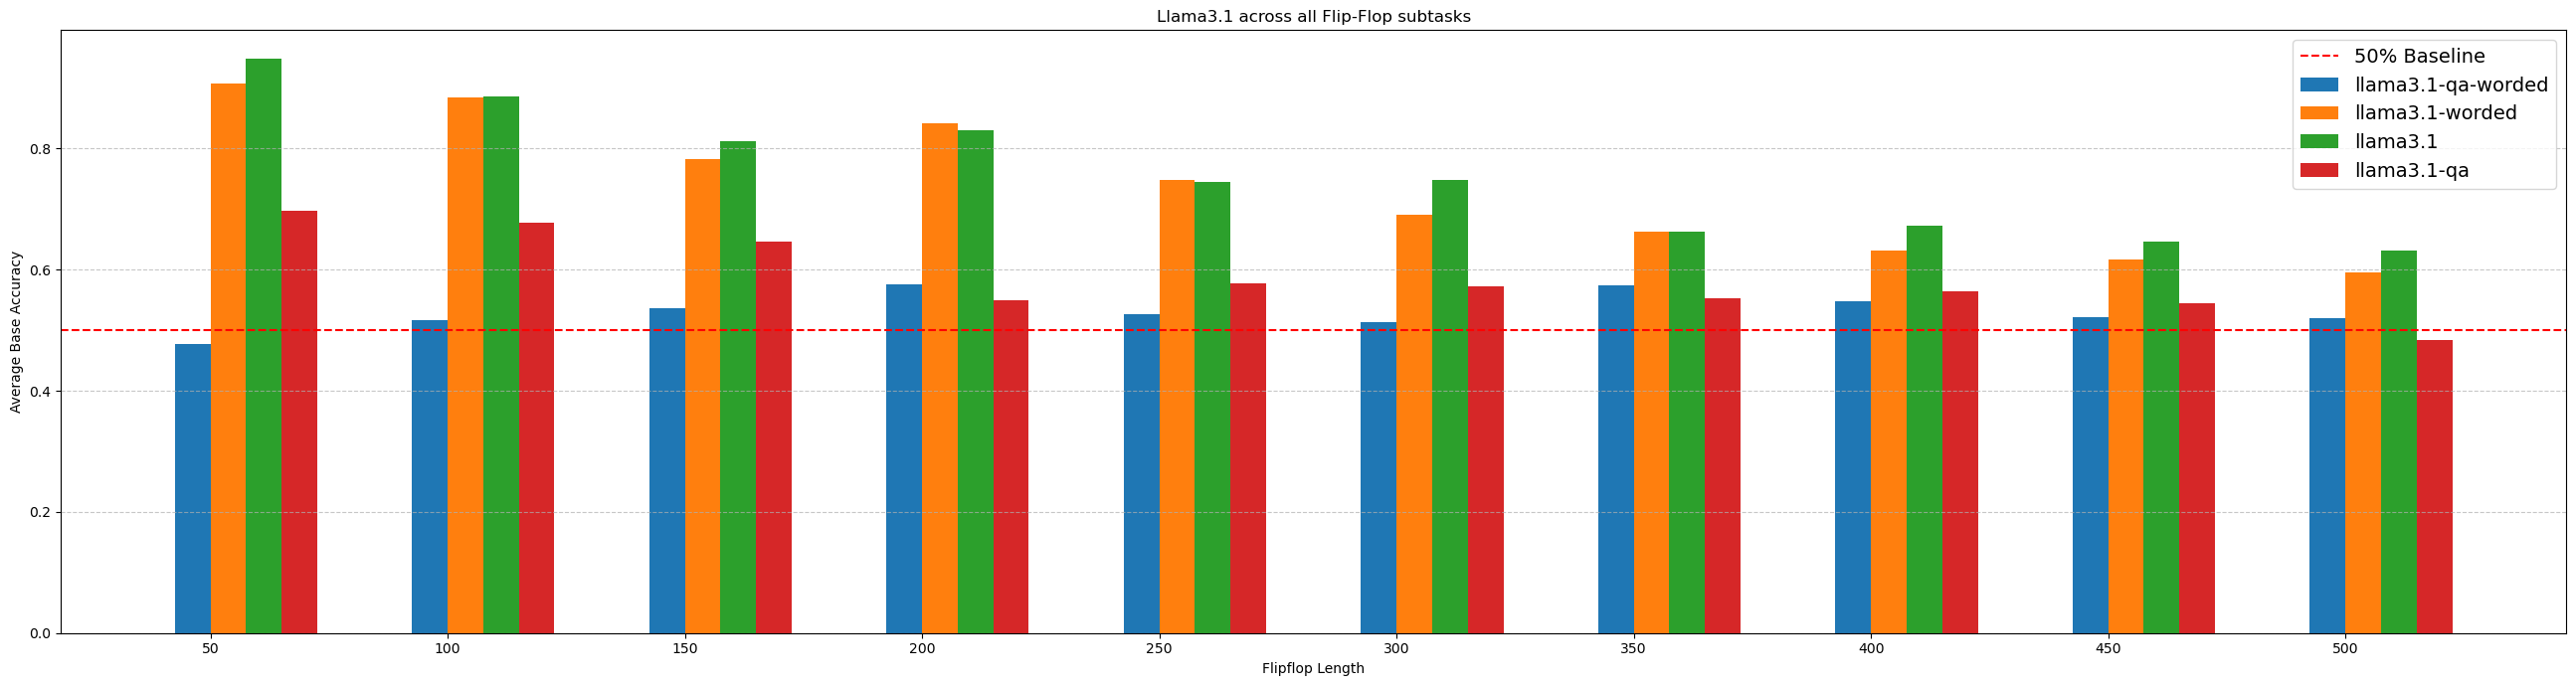

In [67]:
models = {
    "llama3.1-qa-worded": ["llama3.1_70B/sparse-qa-worded/s1", 
                          "llama3.1_70B/sparse-qa-worded/s2", 
                          "llama3.1_70B/sparse-qa-worded/s3", 
                          "llama3.1_70B/sparse-qa-worded/s4", 
                          "llama3.1_70B/sparse-qa-worded/s5"],
    "llama3.1-worded": ["llama3.1_70B/sparse-worded/s1", 
                 "llama3.1_70B/sparse-worded/s2", 
                 "llama3.1_70B/sparse-worded/s3", 
                 "llama3.1_70B/sparse-worded/s4", 
                 "llama3.1_70B/sparse-worded/s5"],
    "llama3.1": ["llama3.1_70B/sparse/s1", 
                 "llama3.1_70B/sparse/s2", 
                 "llama3.1_70B/sparse/s3", 
                 "llama3.1_70B/sparse/s4", 
                 "llama3.1_70B/sparse/s5"],
    "llama3.1-qa": ["llama3.1_70B/sparse-qa/s1", 
                 "llama3.1_70B/sparse-qa/s2", 
                 "llama3.1_70B/sparse-qa/s3", 
                 "llama3.1_70B/sparse-qa/s4", 
                 "llama3.1_70B/sparse-qa/s5"],
}
title = "Llama3.1 across all Flip-Flop subtasks"
output_path = "graphs/llama3.1_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# OLMo 7B on all substasks

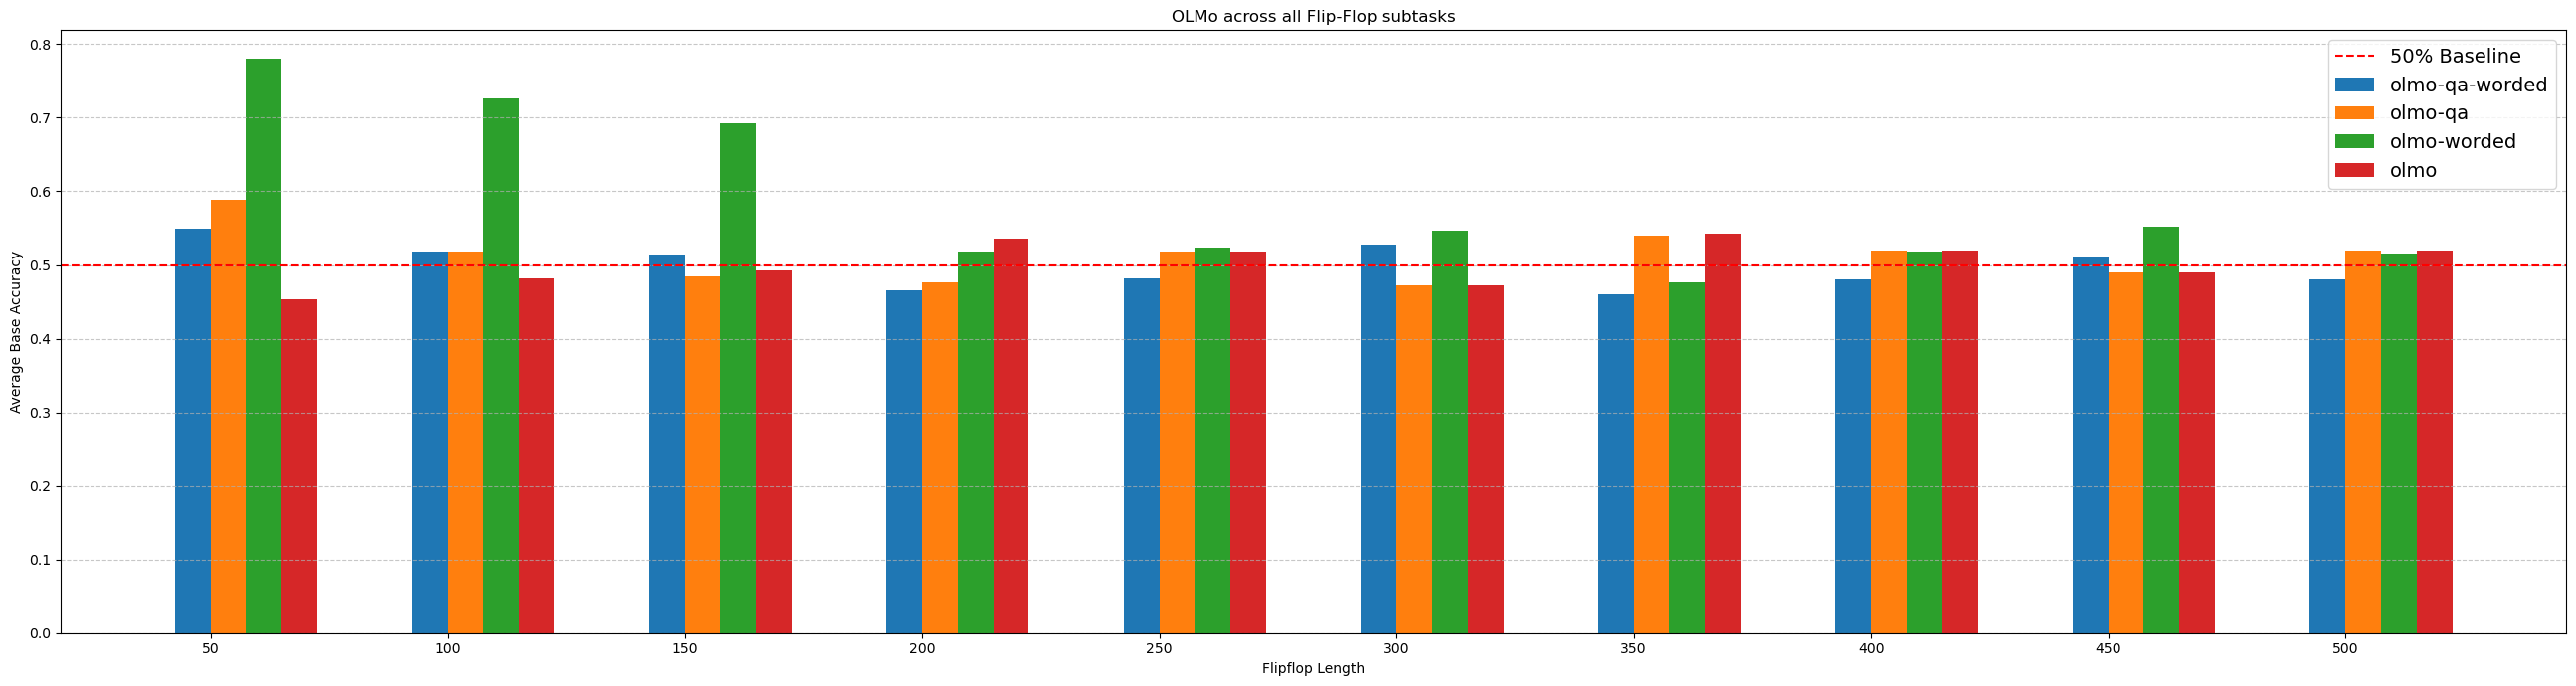

In [64]:
models = {
    "olmo-qa-worded": ["OLMo_7B/sparse-qa-worded/s1", 
                          "OLMo_7B/sparse-qa-worded/s2", 
                          "OLMo_7B/sparse-qa-worded/s3", 
                          "OLMo_7B/sparse-qa-worded/s4", 
                          "OLMo_7B/sparse-qa-worded/s5"],
    "olmo-qa": ["OLMo_7B/sparse-qa/s1", 
                          "OLMo_7B/sparse-qa/s2", 
                          "OLMo_7B/sparse-qa/s3", 
                          "OLMo_7B/sparse-qa/s4", 
                          "OLMo_7B/sparse-qa/s5"],
    "olmo-worded": ["OLMo_7B/sparse-worded/s1", 
                          "OLMo_7B/sparse-worded/s2", 
                          "OLMo_7B/sparse-worded/s3", 
                          "OLMo_7B/sparse-worded/s4", 
                          "OLMo_7B/sparse-worded/s5"],
    "olmo": ["OLMo_7B/sparse/s1", 
                          "OLMo_7B/sparse/s2", 
                          "OLMo_7B/sparse/s3", 
                          "OLMo_7B/sparse/s4", 
                          "OLMo_7B/sparse/s5"],
}


title = "OLMo across all Flip-Flop subtasks"
output_path = "graphs/olmo_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# OLMo-instruct 7B on all subtasks

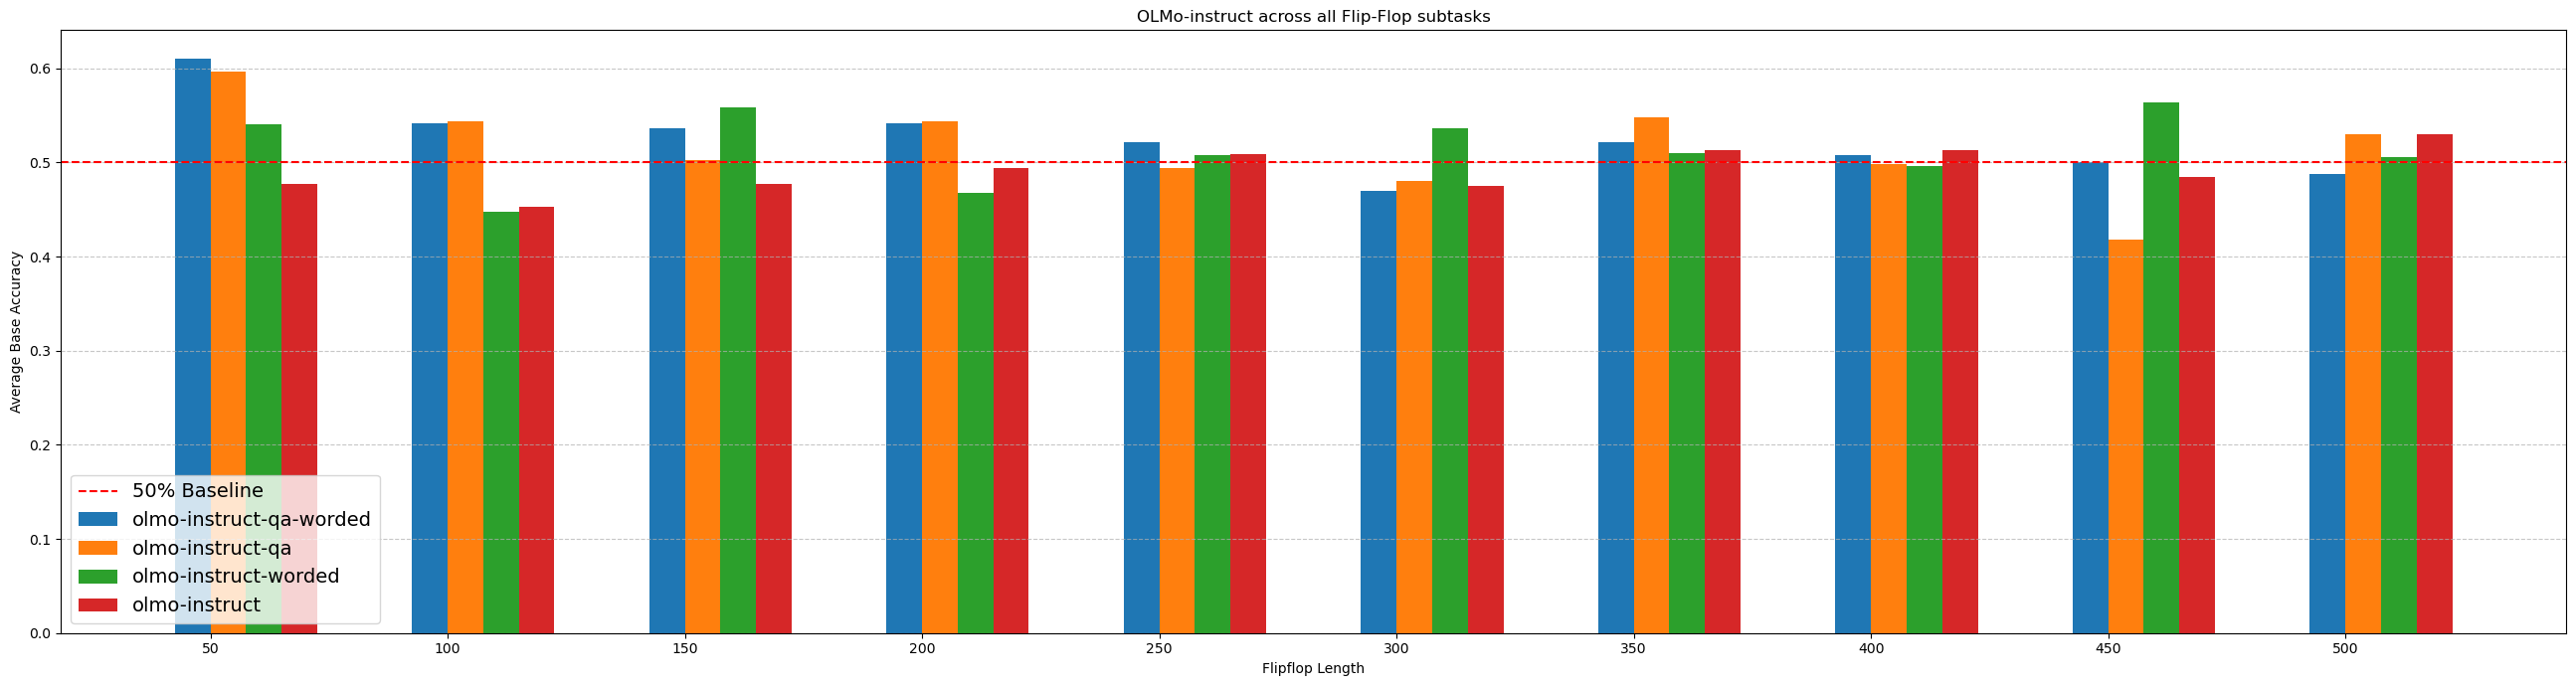

In [65]:
models = {
    "olmo-instruct-qa-worded": ["OLMo_7B-instruct/sparse-qa-worded/s1", 
                          "OLMo_7B-instruct/sparse-qa-worded/s2", 
                          "OLMo_7B-instruct/sparse-qa-worded/s3", 
                          "OLMo_7B-instruct/sparse-qa-worded/s4", 
                          "OLMo_7B-instruct/sparse-qa-worded/s5"],
    "olmo-instruct-qa": ["OLMo_7B-instruct/sparse-qa/s1", 
                          "OLMo_7B-instruct/sparse-qa/s2", 
                          "OLMo_7B-instruct/sparse-qa/s3", 
                          "OLMo_7B-instruct/sparse-qa/s4", 
                          "OLMo_7B-instruct/sparse-qa/s5"],
    "olmo-instruct-worded": ["OLMo_7B-instruct/sparse-worded/s1", 
                          "OLMo_7B-instruct/sparse-worded/s2", 
                          "OLMo_7B-instruct/sparse-worded/s3", 
                          "OLMo_7B-instruct/sparse-worded/s4", 
                          "OLMo_7B-instruct/sparse-worded/s5"],
    "olmo-instruct": ["OLMo_7B-instruct/sparse/s1", 
                          "OLMo_7B-instruct/sparse/s2", 
                          "OLMo_7B-instruct/sparse/s3", 
                          "OLMo_7B-instruct/sparse/s4", 
                          "OLMo_7B-instruct/sparse/s5"],
}


title = "OLMo-instruct across all Flip-Flop subtasks"
output_path = "graphs/olmo-instruct_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# Llama 3.1-instruct 70B on all subtasks

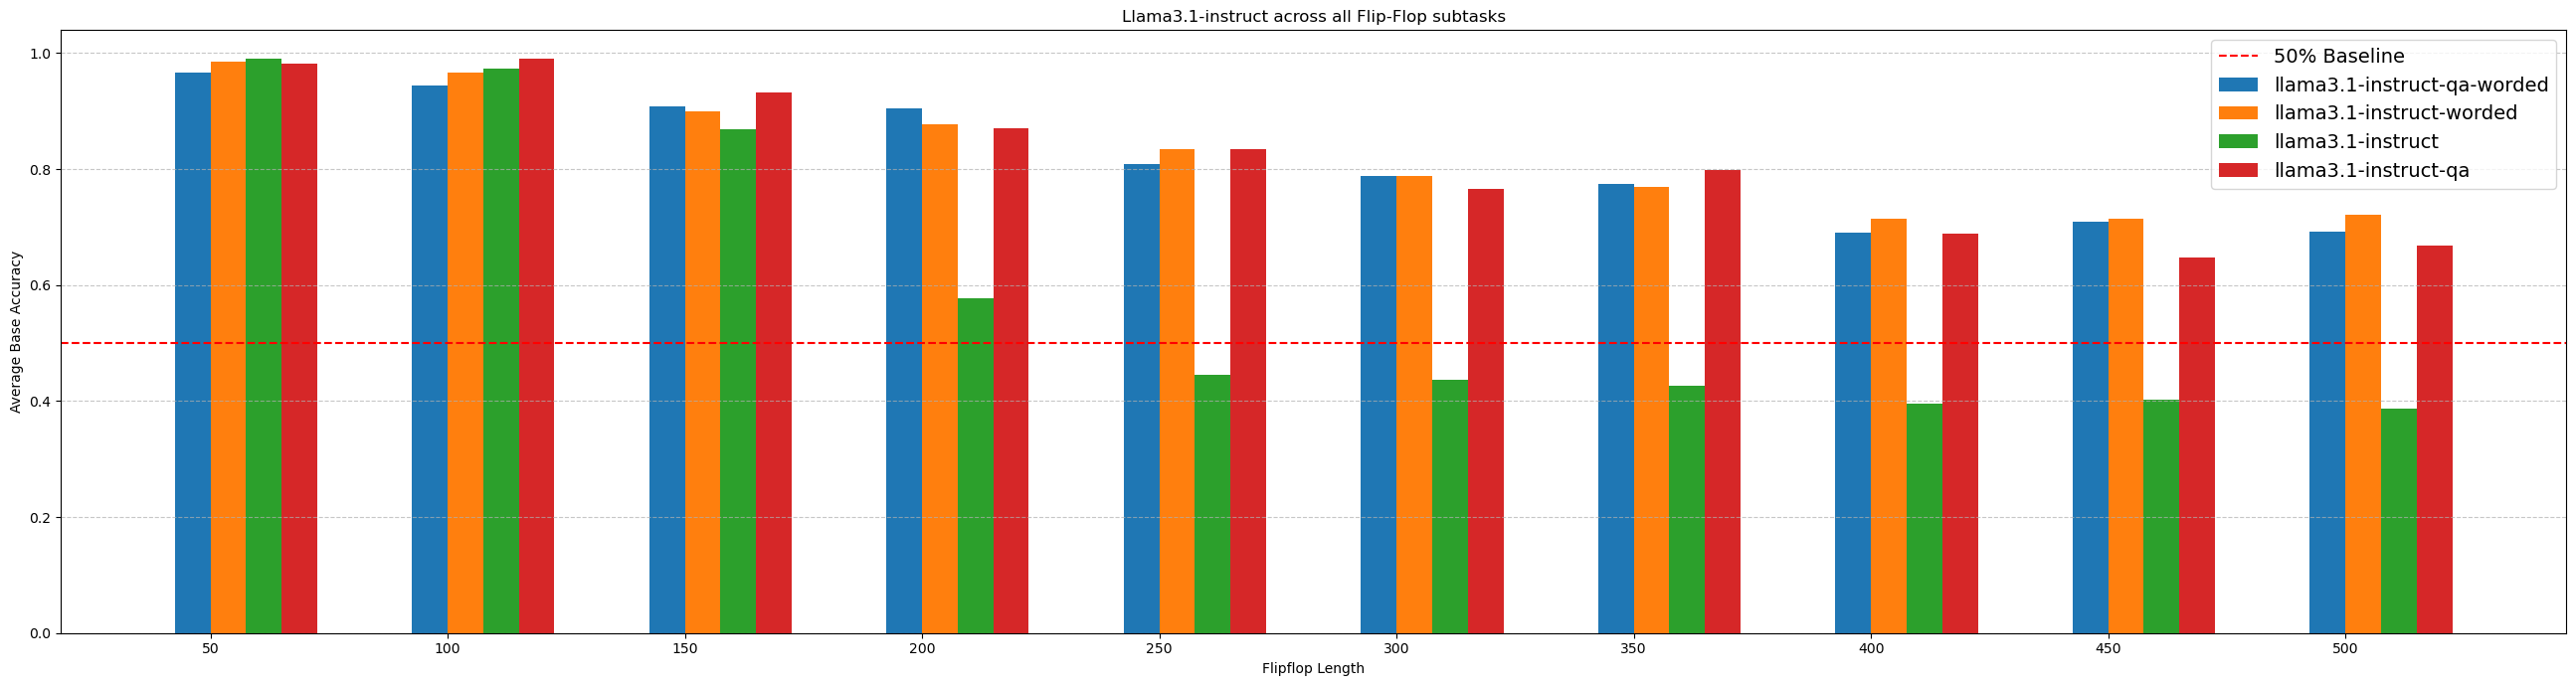

In [68]:
models = {
    "llama3.1-instruct-qa-worded": ["llama3.1_70B-instruct/sparse-qa-worded/s1", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s2", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s3", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s4", 
                          "llama3.1_70B-instruct/sparse-qa-worded/s5"],
    "llama3.1-instruct-worded": ["llama3.1_70B-instruct/sparse-worded/s1", 
                 "llama3.1_70B-instruct/sparse-worded/s2", 
                 "llama3.1_70B-instruct/sparse-worded/s3", 
                 "llama3.1_70B-instruct/sparse-worded/s4", 
                 "llama3.1_70B-instruct/sparse-worded/s5"],
    "llama3.1-instruct": ["llama3.1_70B-instruct/sparse/s1", 
                 "llama3.1_70B-instruct/sparse/s2", 
                 "llama3.1_70B-instruct/sparse/s3", 
                 "llama3.1_70B-instruct/sparse/s4", 
                 "llama3.1_70B-instruct/sparse/s5"],
    "llama3.1-instruct-qa": ["llama3.1_70B-instruct/sparse-qa/s1", 
                 "llama3.1_70B-instruct/sparse-qa/s2", 
                 "llama3.1_70B-instruct/sparse-qa/s3", 
                 "llama3.1_70B-instruct/sparse-qa/s4", 
                 "llama3.1_70B-instruct/sparse-qa/s5"],
}
title = "Llama3.1-instruct across all Flip-Flop subtasks"
output_path = "graphs/llama3.1-instruct_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)

# Llama 3.3-instruct 70B on all subtasks

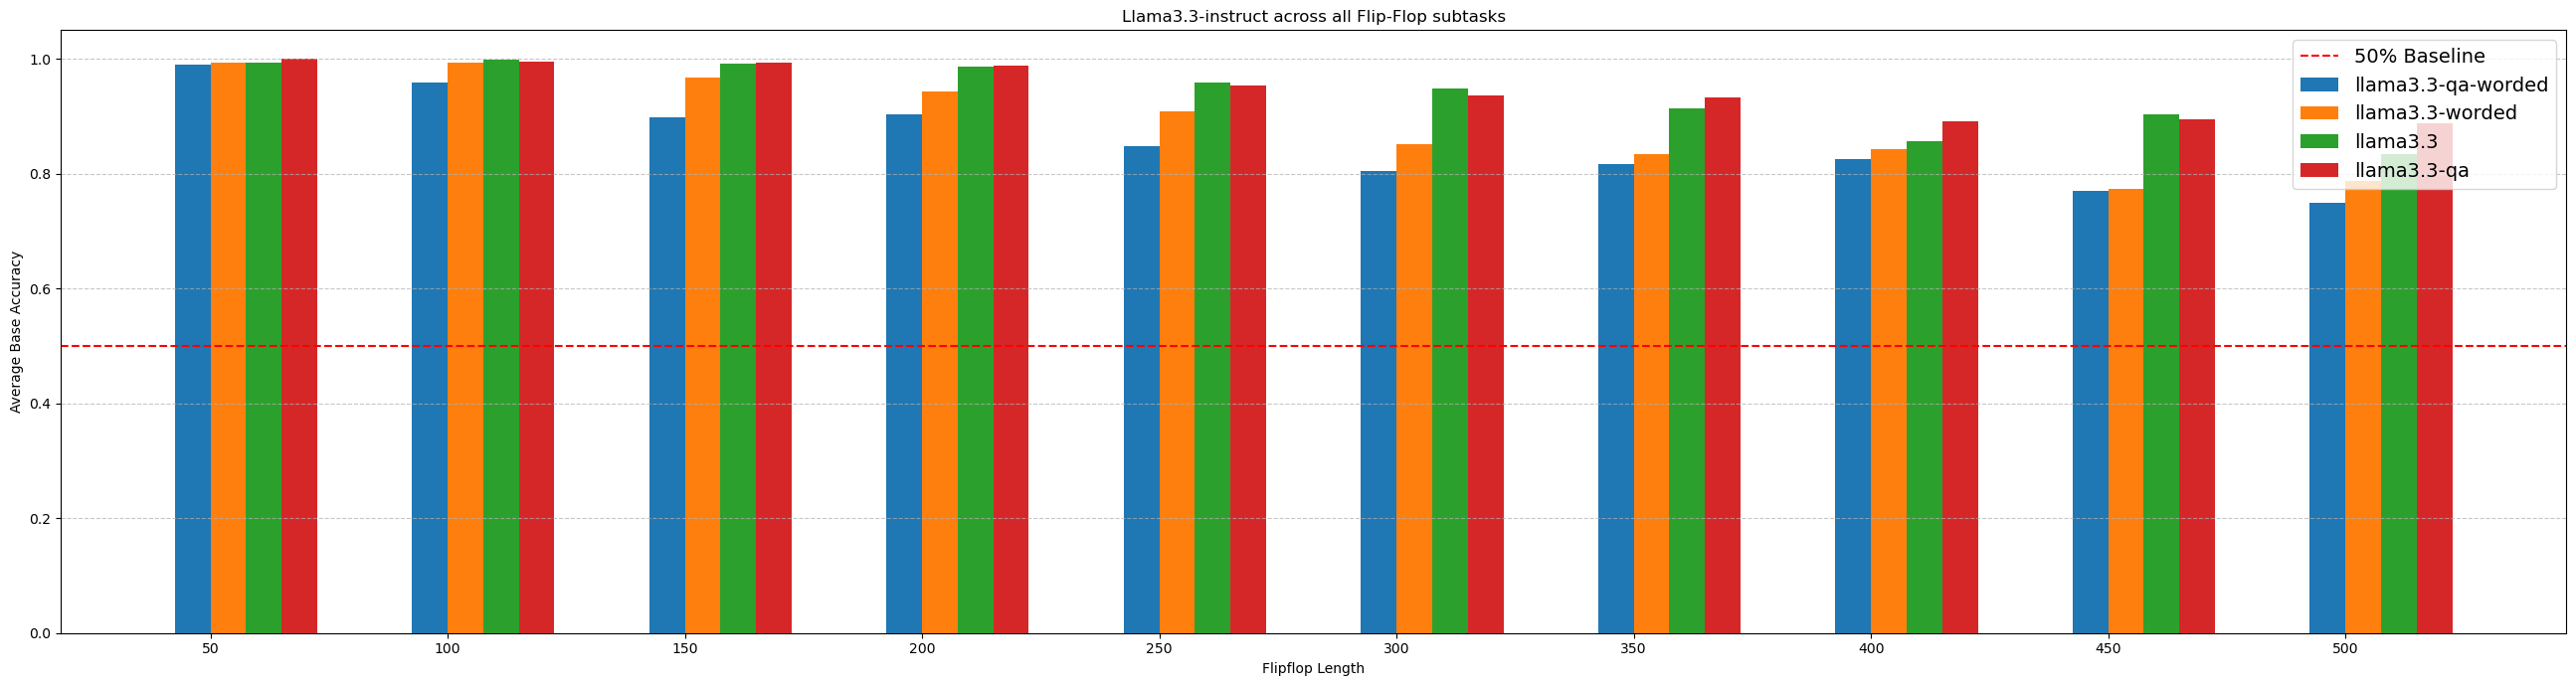

In [69]:
models = {
    "llama3.3-qa-worded": ["llama3.3_70B-instruct/sparse-qa-worded/s1", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s2", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s3", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s4", 
                          "llama3.3_70B-instruct/sparse-qa-worded/s5"],
    "llama3.3-worded": ["llama3.3_70B-instruct/sparse-worded/s1", 
                 "llama3.3_70B-instruct/sparse-worded/s2", 
                 "llama3.3_70B-instruct/sparse-worded/s3", 
                 "llama3.3_70B-instruct/sparse-worded/s4", 
                 "llama3.3_70B-instruct/sparse-worded/s5"],
    "llama3.3": ["llama3.3_70B-instruct/sparse/s1", 
                 "llama3.3_70B-instruct/sparse/s2", 
                 "llama3.3_70B-instruct/sparse/s3", 
                 "llama3.3_70B-instruct/sparse/s4", 
                 "llama3.3_70B-instruct/sparse/s5"],
    "llama3.3-qa": ["llama3.3_70B-instruct/sparse-qa/s1", 
                 "llama3.3_70B-instruct/sparse-qa/s2", 
                 "llama3.3_70B-instruct/sparse-qa/s3", 
                 "llama3.3_70B-instruct/sparse-qa/s4", 
                 "llama3.3_70B-instruct/sparse-qa/s5"],
}
title = "Llama3.3-instruct across all Flip-Flop subtasks"
output_path = "graphs/llama3.3-instruct_across_sparse_flipflop.png"
plot_model_accuracy(models, title, output_path)